# Yelp Reviews Sentiment Analysis

## Data Loading

In [1]:
# Setup for kaggle API

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# Downloading dataset via Kaggle

!kaggle datasets download -d yacharki/yelp-reviews-for-sentianalysis-binary-np-csv

Dataset URL: https://www.kaggle.com/datasets/yacharki/yelp-reviews-for-sentianalysis-binary-np-csv
License(s): ODC Public Domain Dedication and Licence (PDDL)
 95% 153M/162M [00:02<00:00, 89.9MB/s]
100% 162M/162M [00:02<00:00, 81.6MB/s]


In [3]:
# Extracting data from ZipFile

import zipfile
zipfile_ref = zipfile.ZipFile('/content/yelp-reviews-for-sentianalysis-binary-np-csv.zip','r')
zipfile_ref.extractall('/content')
zipfile_ref.close()

## Exploratory Data Analysis

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [5]:
df_train = pd.read_csv('/content/yelp_review_sa_binary_csv/train.csv')
df_test = pd.read_csv('/content/yelp_review_sa_binary_csv/test.csv')

In [6]:
df_train.head(5)

,class_index,review_text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [7]:
df_test.head(5)

,class_index,review_text
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [8]:
print(f'Train shape: {df_train.shape}')
print(f'Test shape: {df_test.shape}')

Train shape: (560000, 2)
Test shape: (38000, 2)


In [9]:
# Combining dataset

df = pd.concat([df_train, df_test], ignore_index=True)

In [10]:
df.head(5)

,class_index,review_text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [11]:
df.shape

(598000, 2)

In [12]:
df.size

1196000

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598000 entries, 0 to 597999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   class_index  598000 non-null  int64 
 1   review_text  598000 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.1+ MB


In [14]:
df.describe()

,class_index
count,598000.0
mean,1.5
std,0.5
min,1.0
25%,1.0
50%,1.5
75%,2.0
max,2.0


In [15]:
df.isnull().sum()

,0
class_index,0
review_text,0


In [16]:
df.duplicated().sum()

0

In [17]:
df.nunique()

,0
class_index,2
review_text,598000


## Data Visualization

In [18]:
# Renaming the column name and labeling the emotions

df.rename(columns={'review_text': 'Text', 'class_index': 'Label'}, inplace=True)

df['Label'] = df['Label'].replace({
    1: 'Negative',
    2: 'Positive',
})

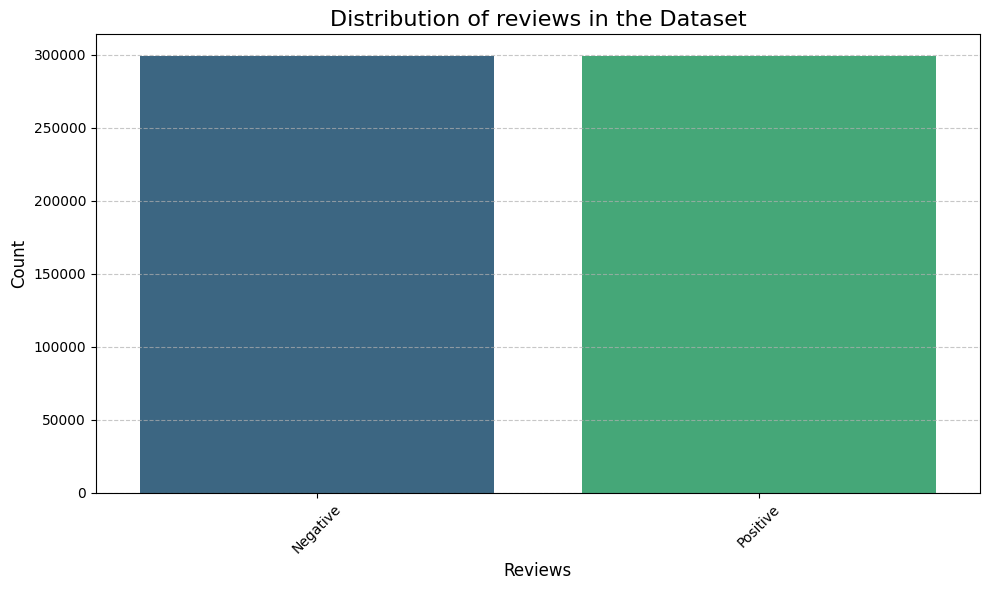

In [19]:
# Visualizing Distribution of Reviews

label_counts = df['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of reviews in the Dataset', fontsize=16)
plt.xlabel('Reviews', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

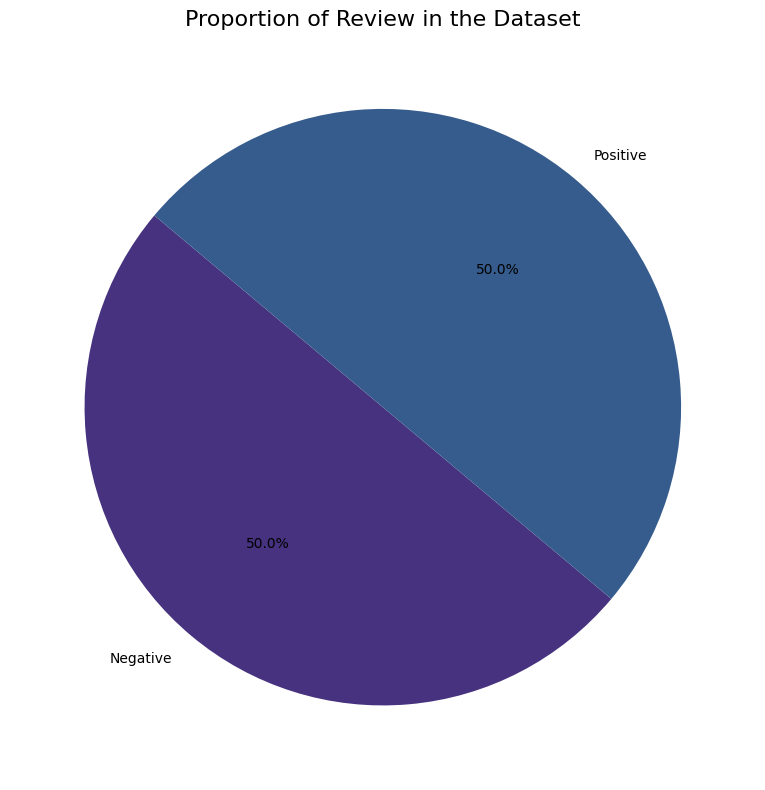

In [20]:
# Visualizing Reviews Distribution

plt.figure(figsize=(8, 8))

df['Label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Proportion of Review in the Dataset', fontsize=16)
plt.ylabel('')
plt.tight_layout()
plt.show()

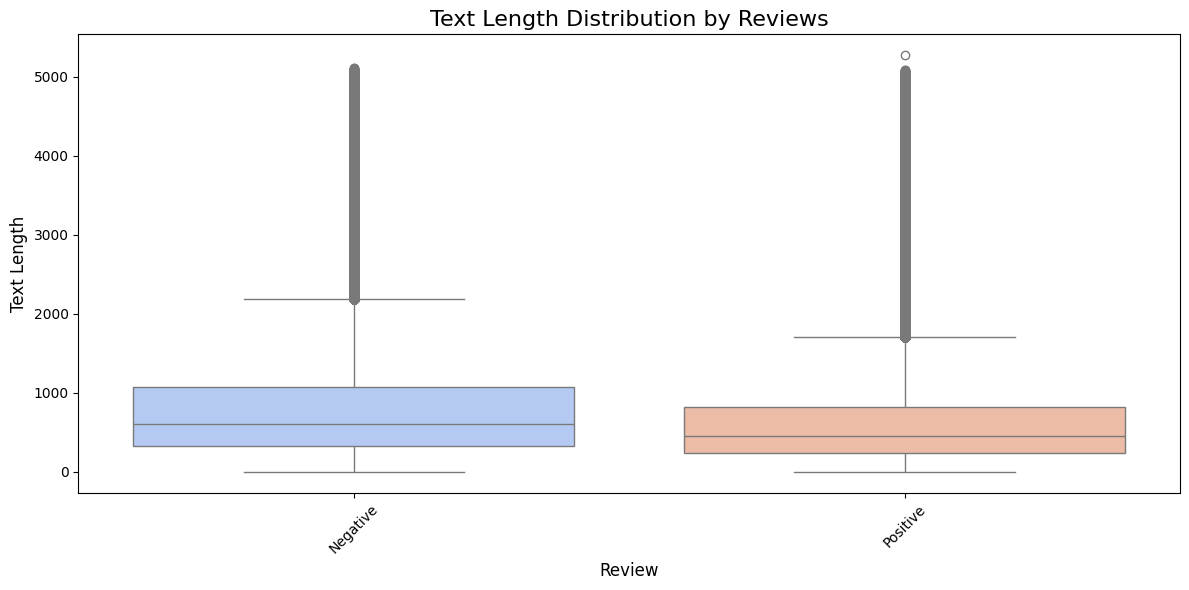

In [21]:
# Representing Text Length Distribution by Reviews

df['Text_Length'] = df['Text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Text_Length', data=df, palette='coolwarm')
plt.title('Text Length Distribution by Reviews', fontsize=16)
plt.xlabel('Review', fontsize=12)
plt.ylabel('Text Length', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

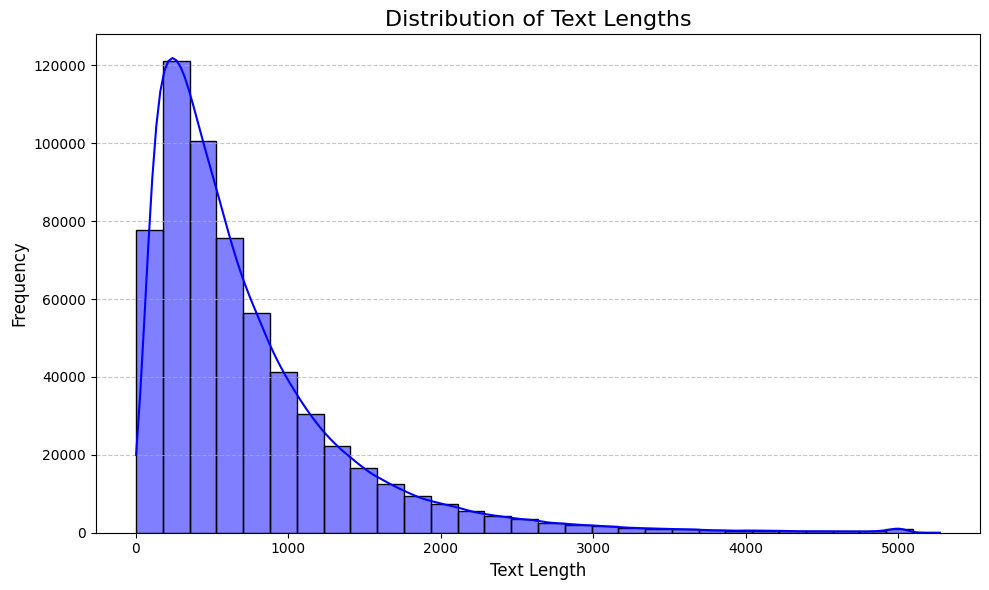

In [22]:
# Plotting Histogram for Distributon of Text Lengths

plt.figure(figsize=(10, 6))
df['Text_Length'] = df['Text'].apply(len)
sns.histplot(df['Text_Length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

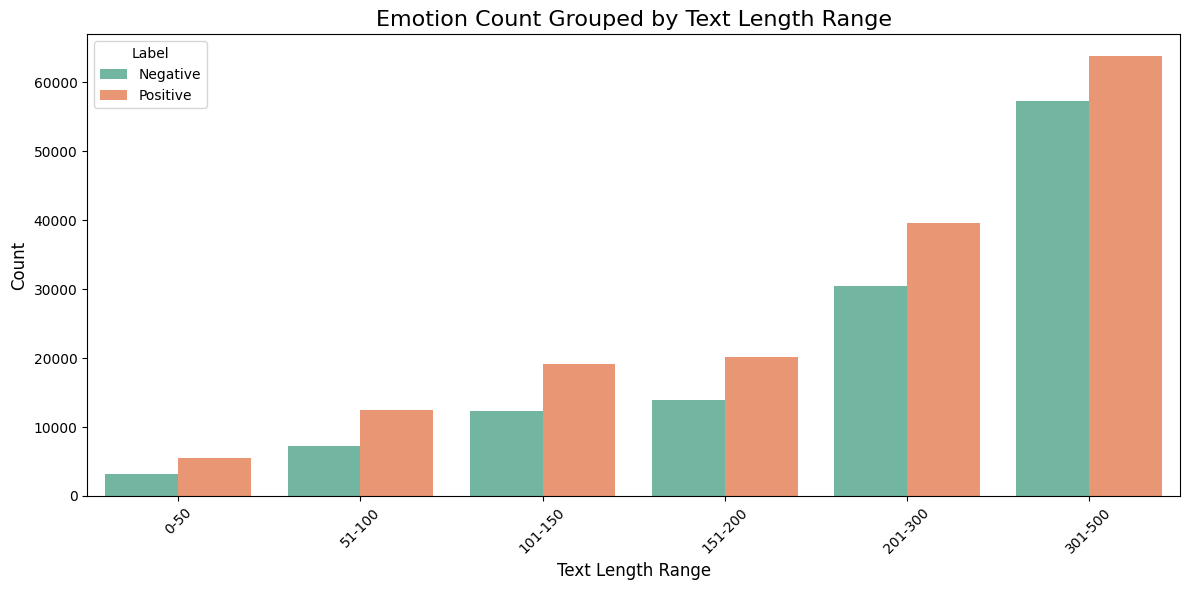

In [23]:
# Visualizing Review Count Grouped by Text Length Range

df['Length_Bin'] = pd.cut(df['Text_Length'], bins=[0, 50, 100, 150, 200, 300, 500],
                          labels=['0-50', '51-100', '101-150', '151-200', '201-300', '301-500'])

plt.figure(figsize=(12, 6))
sns.countplot(x='Length_Bin', hue='Label', data=df, palette='Set2')
plt.title('Emotion Count Grouped by Text Length Range', fontsize=16)
plt.xlabel('Text Length Range', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

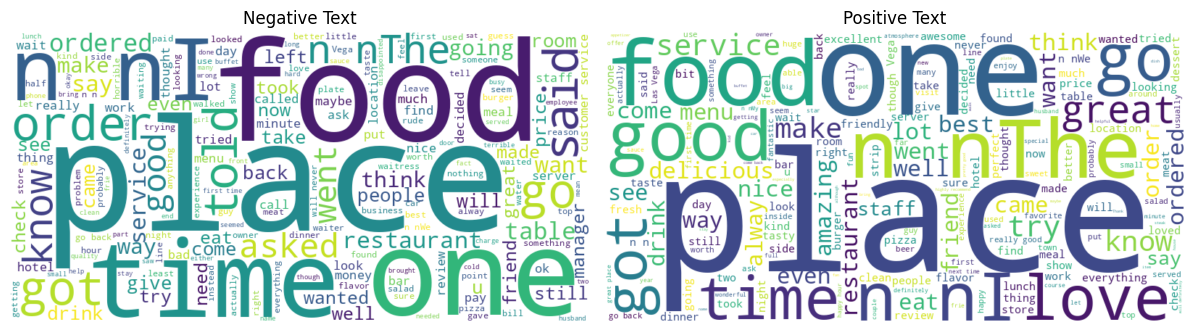

In [24]:
# Creating WordCloud for Both the Labels

from wordcloud import WordCloud

Review_dfs = {
    'Negative': df[df['Label'] == 'Negative'],
    'Positive': df[df['Label'] == 'Positive'],
}

plt.figure(figsize=(18, 9))
for i, (review, subset) in enumerate(Review_dfs.items(), 1):
    combined_text = ' '.join(subset['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{review} Text')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Cleaning & Preprocessing

In [59]:
import re
import tqdm
import nltk
import unicodedata
import contractions

from bs4 import BeautifulSoup
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
# Creating a Pipeline for Data Cleaning

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()
        norm_docs.append(doc)

    return norm_docs

In [61]:
# Shuffling Data

train = df_train.sample(frac=1)
test = df_test.sample(frac=1)

In [62]:
# Taking small peice of the dataset to avoid long training time

test = df_test.iloc[:38000,:]
val = df_train.iloc[:50000,:]
train = df_train.iloc[50000:,:]
train = df_train.iloc[:50000,:]

In [63]:
X_train = train['review_text'].values
y_train = train['class_index'].values

X_val = val['review_text'].values
y_val = val['class_index'].values

X_test = test['review_text'].values
y_test = test['class_index'].values

In [64]:
# Preprocessing

X_train = pre_process_corpus(X_train)
X_val = pre_process_corpus(X_val)
X_test = pre_process_corpus(X_test)

100%|██████████| 38000/38000 [00:07<00:00, 5375.55it/s]


In [65]:
# Tokenization

from tensorflow.keras.preprocessing.text import Tokenizer

t = Tokenizer(oov_token='<UNK>')
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [66]:
# Transforming  to Sequences

X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

In [67]:
# Sequence Normalization

from tensorflow.keras.preprocessing import sequence

X_train = sequence.pad_sequences(X_train, maxlen=800)
X_test = sequence.pad_sequences(X_test, maxlen=800)
X_val = sequence.pad_sequences(X_val, maxlen=800)

In [68]:
# Label Encoding (positive --> 1, negative --> 0)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

## Model Building

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [75]:
model = Sequential([

    Embedding(input_dim=len(t.word_index), output_dim=300, input_length=800),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')

])

In [76]:
model.compile(

    loss='BinaryCrossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']

)

model.build(input_shape=(None, 800))

In [77]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 800, 300)            │      36,022,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 24)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,117,525 (137.78 MB)

 Trainable params: 36,117,525 (137.78 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=5,
    verbose=1
)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 61ms/step - accuracy: 0.7513 - loss: 0.4776 - val_accuracy: 0.9428 - val_loss: 0.1635
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 145s 63ms/step - accuracy: 0.9408 - loss: 0.1633 - val_accuracy: 0.9651 - val_loss: 0.1126
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 61ms/step - accuracy: 0.9627 - loss: 0.1067 - val_accuracy: 0.9766 - val_loss: 0.0797
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 95s 61ms/step - accuracy: 0.9737 - loss: 0.0795 - val_accuracy: 0.9849 - val_loss: 0.0496
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 61ms/step - accuracy: 0.9822 - loss: 0.0569 - val_accuracy: 0.9893 - val_loss: 0.0369


## Model Prediction

In [79]:
history_df=pd.DataFrame(history.history)
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.84902,0.338647,0.94282,0.163494
1,0.93882,0.164718,0.96512,0.112556
2,0.96022,0.112560,0.97662,0.079741
3,0.97192,0.082036,0.98488,0.049556
4,0.98006,0.060782,0.98930,0.036862


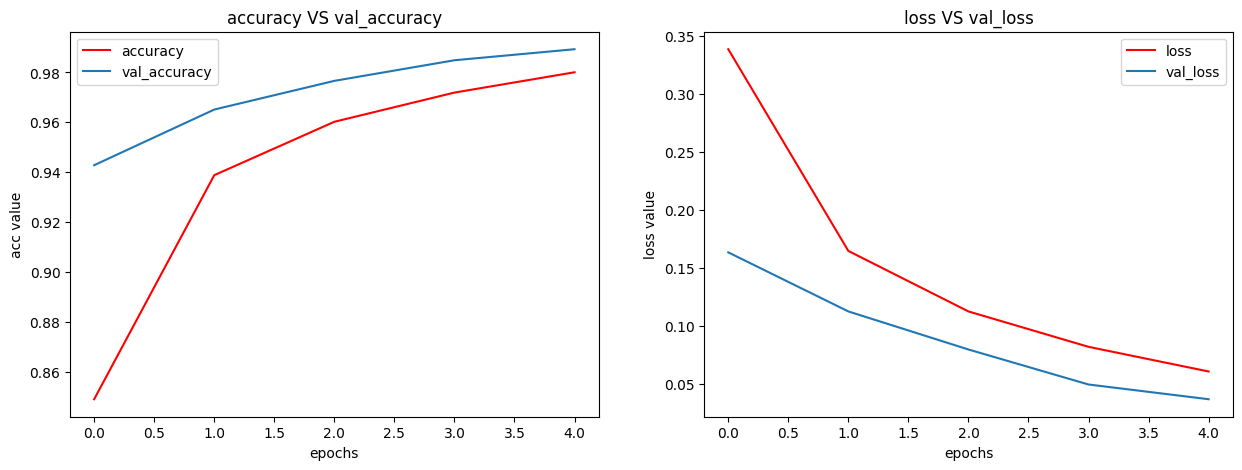

In [80]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()